In [1]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('Mall_Customers.csv') 

In [3]:
# 그래프 한글 깨짐 방지 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [4]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 1. Preprocessing & EDA

In [5]:
#의미없는 CustomerID 변수를 제거하고 바로 데이터에 적용함.
data.drop('CustomerID', axis=1, inplace = True)

In [6]:
def encoding_sex(x):
    if x['Gender'] == "Male":
        return 1
    else:
        return 0
#Male = 1 / Female = 0으로 인코딩

In [7]:
#gender변수를 0/1로 인코딩하고 데이터를 업데이트
data['Gender'] = data.apply(encoding_sex, axis=1)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [8]:
from sklearn.preprocessing import MinMaxScaler

#Scailing
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data)

In [9]:
#data를 스케일링한 데이터로 업데이트
data = pd.DataFrame(scaler.fit_transform(data_sc), columns = data.columns)
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.008197,0.051020
3,0.0,0.096154,0.008197,0.775510
4,0.0,0.250000,0.016393,0.397959


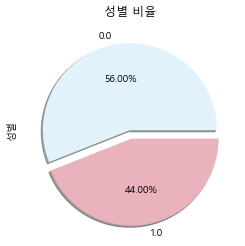

In [10]:
#Gender의 분포를 확인해보자 *잘 안 보이는데 하늘색(56.00%)이 여자입니다.
sex_count = data['Gender'].value_counts()
sex_count.plot.pie(explode=[0,0.1],autopct='%1.2f%%',shadow=True, colors =['#e1f2fb', '#e9b2bc']) 
plt.ylabel('성별')
plt.title('성별 비율')
plt.show()

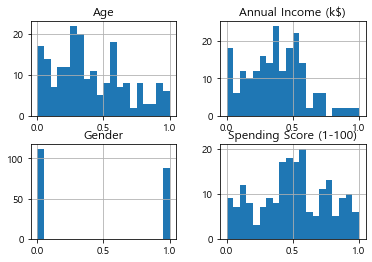

In [11]:
#연속형 변수의 분포를 확인해보자. 다들 적절하게 분포되어 있으므로 이상치를 고려할 필요는 없어 보인다.
data.hist(bins=20)
plt.show()

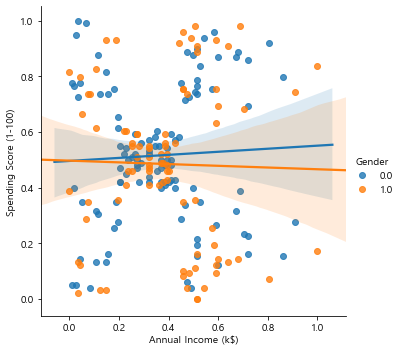

In [12]:
#성별에 따라 본 Annual Income X Spending Score 
sns.lmplot(x='Annual Income (k$)',y='Spending Score (1-100)',hue='Gender',data=data)
plt.show()
#성별에 따른 두 변수의 값은 크게 차이가 없다.

# 2. Modeling

## 2-1. Hierarchical Clustering
계층적 할당 방법을 이용하여 군집을 몇 개로 나누면 좋을 지 봅시다

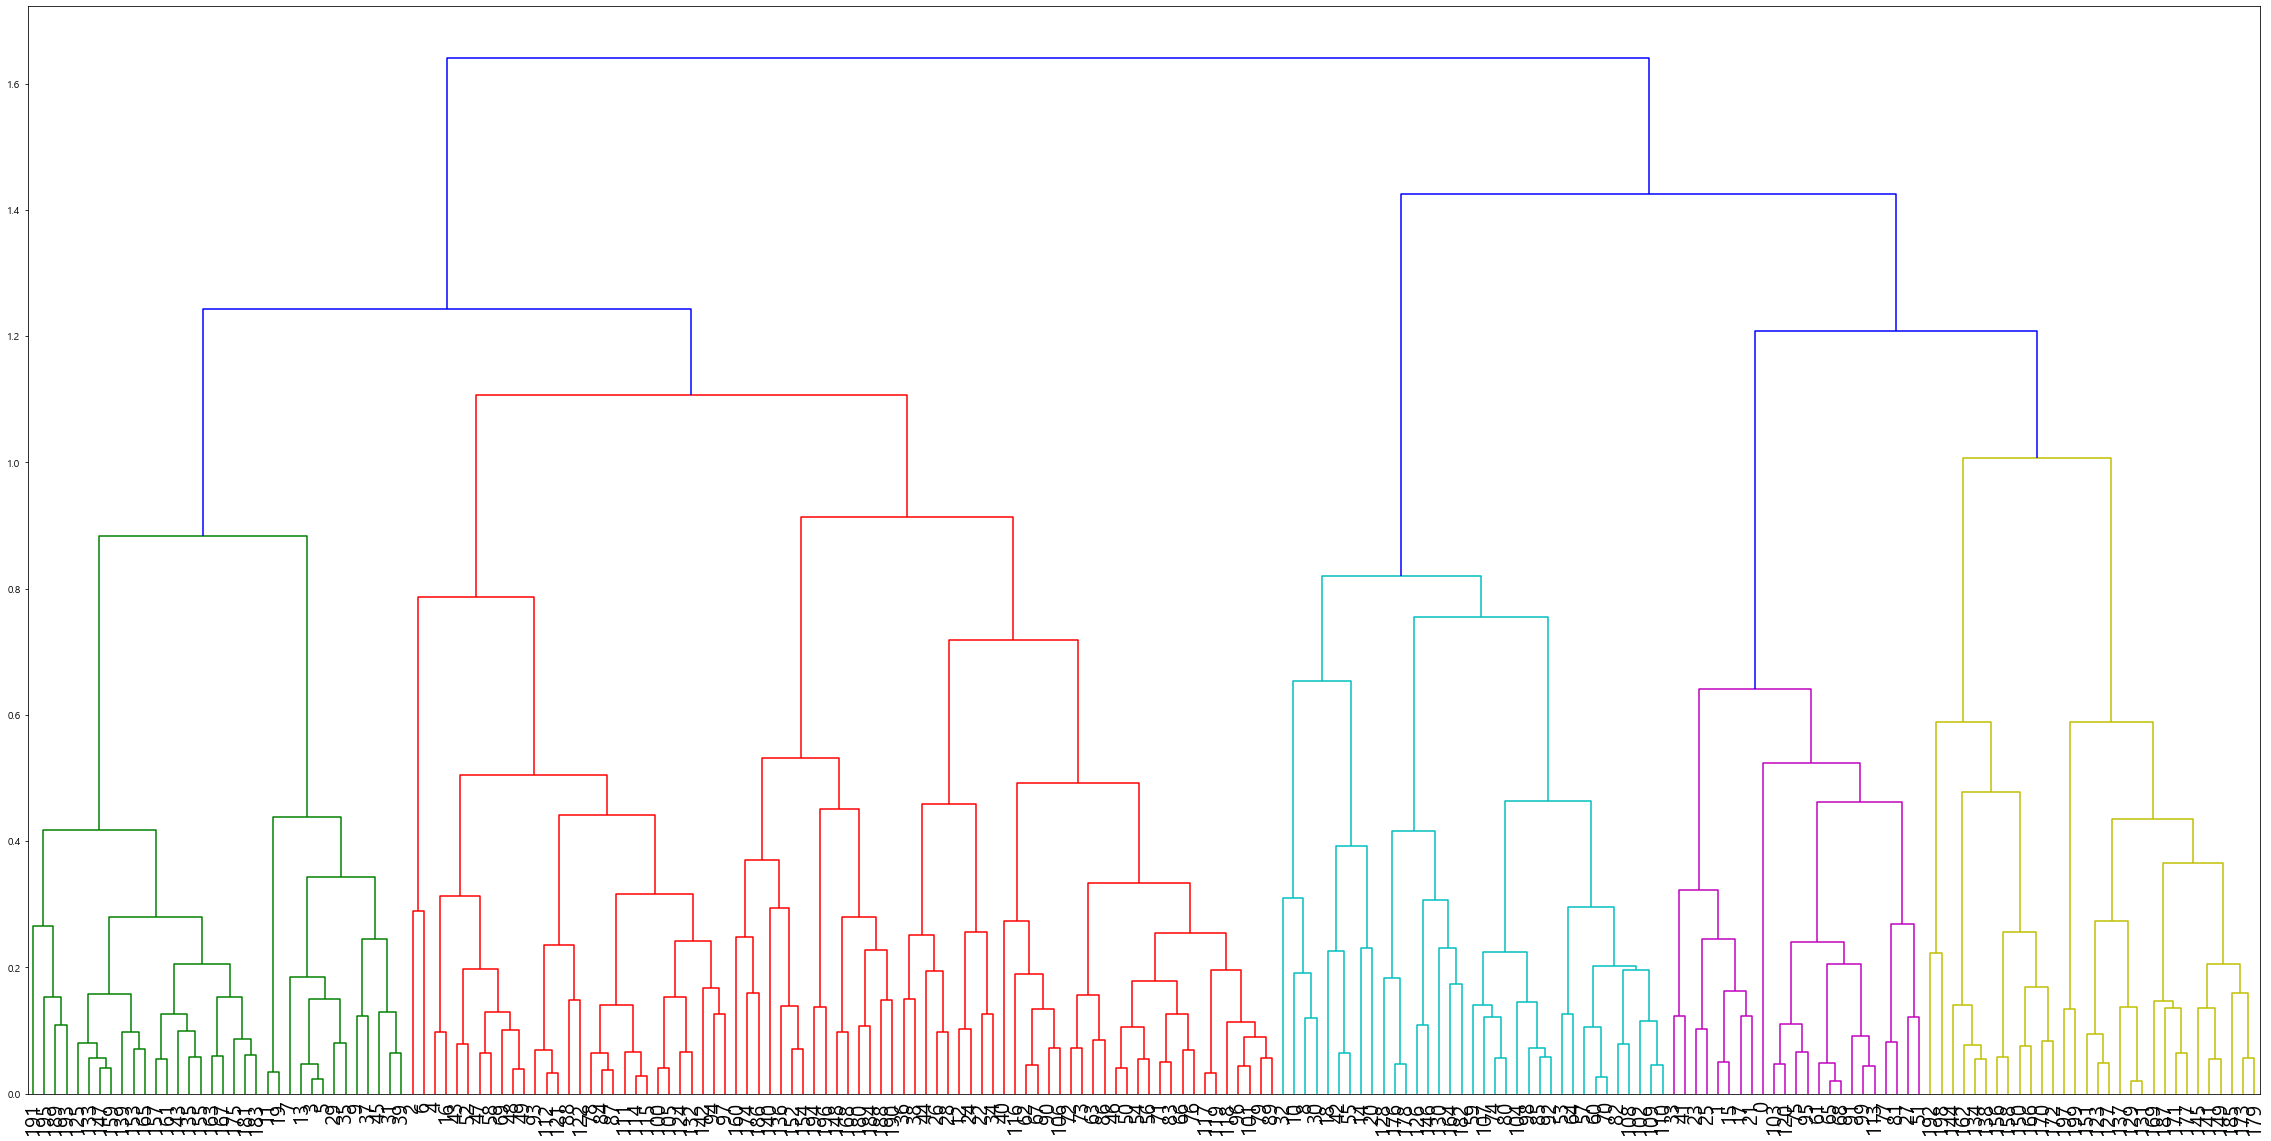

In [13]:
# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the linkage: mergings
# method = 'single','complete', 'average', 'weighted', 'centroid', 'median', 'ward'

mergings = linkage(data, method='complete')
# 완전결합군집 방법으로 Clustering

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(40,20))
dendrogram(mergings,
#            labels = labels.as_matrix(columns=['labels']),
           leaf_rotation=90,
           leaf_font_size=20,
)
plt.show()

#정해진 분류가 없으므로 labels은 주석처리하였음.

덴드로그램을 보아 크게는 2, 3, 5, 7개의 군집을 고려할 수 있음.  
그 중에서도 3개의 군집으로 나누는 것을 먼저 선택하여 분석을 진행

In [14]:
from scipy.cluster.hierarchy import fcluster

# fcluster(linkage함수, 클러스터링을 멈추도록하는 임계값, 거리를 기준으로)
# 위의 덴드로그램에서 클러스터간의 거리가 1.4인 지점에서 자르면 3개의 cluster가 형성됨을 알 수 있다.
# 따라서 임계값을 1.4로 정해서 분석을 실시하면
predict = pd.DataFrame(fcluster(mergings,1.4,criterion='distance'))
predict.columns=['predict'] # predict column에 예측 결과
predict

,predict
0,3
1,3
2,1
3,1
4,1
...,...
195,1
196,1
197,3
198,3


In [15]:
#각각의 그룹에 할당된 개수
predict['predict'].value_counts()

1    112
3     53
2     35
Name: predict, dtype: int64

In [16]:
#실루엣 스코어 결과 값
silhouette_score(data, predict)

0.4395412725206968

In [17]:
#마찬가지로 임계치 1.2인 지점에서 자르면 총 다섯개의 그룹이 생성된다.
predict = pd.DataFrame(fcluster(mergings,1.2,criterion='distance'))
predict.columns=['predict'] # predict column에 예측 결과
predict['predict'].value_counts()

2    78
3    35
1    34
5    30
4    23
Name: predict, dtype: int64

In [18]:
#실루엣 스코어 결과 값 :: 아까 3으로 나누었을 때보다 더 작아졌다.
silhouette_score(data, predict)

0.30316439293019537

## 2-2. K-means Clustering
위의 분석 결과를 바탕으로 비계층적 군집분석 방법인 K-means clustering을 진행해 봅시다

In [19]:
from sklearn.cluster import KMeans

# 비계층적 방법은 사전에 군집의 수를 정의해 주어야 합니다. 위의 결과를 바탕으로 가장 좋은 결과를 낼 수 있을 거라 예상하는 3을 넣어보았습니다.
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(data) #우리는 target value가 없기 때문에 그냥 data자체가 feature만을 담고 있는 변수입니다.

# k-means 방법을 사용하여 data를 세 개의 군집으로 나누고 이를 predict라는 이름으로 저장
predict = pd.DataFrame(model.predict(data))
predict.columns=['predict']

# 이를 data와 합친 새로운 데이터 프레임 r을 생성하고 출력
r = pd.concat([data,predict],axis=1)
r.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,1.0,0.019231,0.000000,0.387755,0
1,1.0,0.057692,0.000000,0.816327,0
2,0.0,0.038462,0.008197,0.051020,1
3,0.0,0.096154,0.008197,0.775510,1
4,0.0,0.250000,0.016393,0.397959,1


In [20]:
r['predict'].value_counts()
#계층적 방법으로 진행한 결과와 사뭇 다르긴 하네요

1    112
2     48
0     40
Name: predict, dtype: int64

In [21]:
#실루엣 스코어 :: 계층적 군집 시 3개로 나누었던 결과보다 더 좋은 점수를 얻었다.
silhouette_score(data, predict)

0.45835255811254244

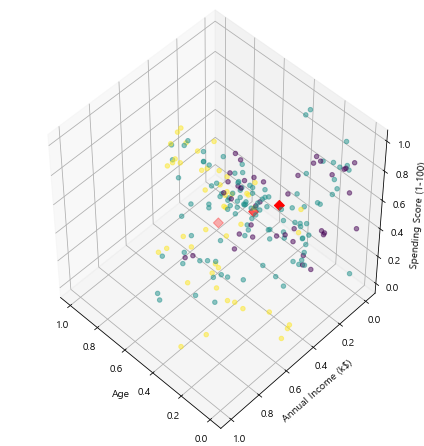

In [22]:
#이를 시각적으로 표현하면 
centers = pd.DataFrame(model.cluster_centers_,columns=['Gender','Age','Annual Income (k$)','Spending Score (1-100)'])
center_x = centers['Age']
center_y = centers['Annual Income (k$)']
center_z = centers['Spending Score (1-100)']

from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Age'],r['Annual Income (k$)'],r['Spending Score (1-100)'],c=r['predict'],alpha=0.5)
ax.scatter(center_x,center_y,center_z,s=50,marker='D',c='r')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()
#군집의 중심점이 빨간색으로 표현되어 있다.

# Elbow Point

Text(0.5, 1.0, 'Elbow curve')

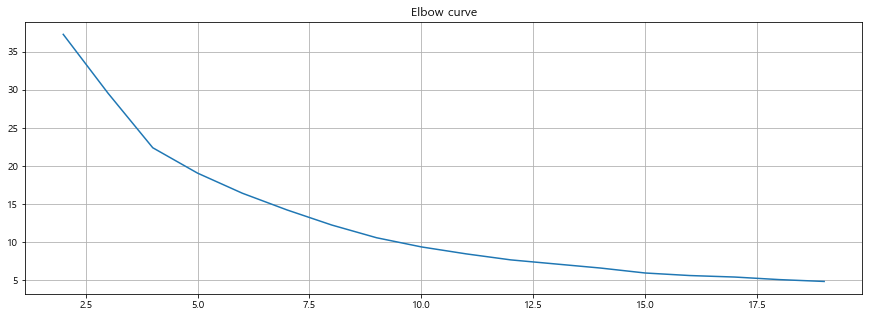

In [23]:
distorsions = []

# 군집 수 K의 변화에 따라
# Inertia Value: 군집화가 된 후에, 각 중심점에서 군집내의 데이터간의 거리를 합산한 것
# 즉, 군집의 응집도를 나타내는 값
# 이 값을 구해 그래프로 그린다!
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

# 급격하게 하강하다가 변화의 폭이 크지 않는 지점 Elbow Point를 찾는다.
# 군집수 3~4정도가 elbow point로 보이는데, 이외에도 10정도까지 고려해볼 만한 가치가 있다고 생각

## 2-3. DBSCAN
k-means 가 거리기반이었다면, 밀도 기반의 계산 방식을 사용한 dbscan을 사용해봅시다

- dbscan 모델에는 두 가지 하이퍼 파라미터가 존재합니다
   1.  eps : 군집의 기준이 되는 원과 점 사이의 반지름
   2. min_samples : core point라고 분류할 점의 개수
   
   
- 먼저 초기값을 지정하고, 그 뒤에 적절히 튜닝하자!
-그렇다면 초기값을 지정하는 기준은?

In [24]:
from sklearn.neighbors import NearestNeighbors
#k-dist를 이용하자!
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

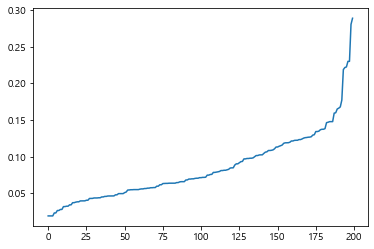

In [25]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

급격하게 변하는 지점이 0.15정도 이고, 이때의 minpts가 5이다.  
(그런데 minpts는 어떤 값으로 지정하면 좋을 지 어떻게 아나요?)

In [26]:
#위의 결과를 바탕으로 DBSCAN 모델을 생성해봅시다
from sklearn.cluster import DBSCAN

#모델을 생성하고 파라미터를 각각 대입
model = DBSCAN(eps=0.15,min_samples=3)

#모델을 적합시키고 이를 바탕으로 분류한 결과를 predict에 데이터 프레임 형태로 저장
predict = pd.DataFrame(model.fit_predict(data))
predict.columns=['predict']

# 결과를 기존 data와 합쳐 r이라는 새로운 데이터 프레임에 저장
r = pd.concat([data,predict],axis=1)

In [27]:
r.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,1.0,0.019231,0.000000,0.387755,-1
1,1.0,0.057692,0.000000,0.816327,0
2,0.0,0.038462,0.008197,0.051020,-1
3,0.0,0.096154,0.008197,0.775510,1
4,0.0,0.250000,0.016393,0.397959,3


In [28]:
r['predict'].value_counts()
# -1값은 노이즈 값, 총 군집은 13개로 나누어졌고 노이즈 포인트는 21개가 있다. 하이퍼 파라미터가 별로 좋지 않았던 듯함.

 1     60
 4     23
-1     21
 7     20
 6     16
 3     11
 5     10
 0     10
 10     8
 11     6
 9      4
 8      4
 2      4
 12     3
Name: predict, dtype: int64

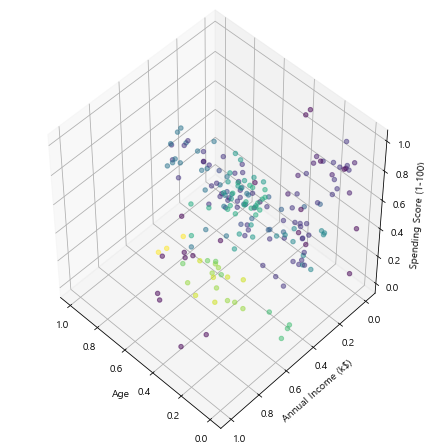

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['Age'],r['Annual Income (k$)'],r['Spending Score (1-100)'],c=r['predict'],alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
plt.show()

In [30]:
silhouette_score(data, predict)
#분석 중 최악의 스코어가 나왔다. 하이퍼 파라미터를 적절히 조정하여 군집 수를 줄여보자.

0.21915318713343657

In [31]:
#min_samples를 8로, eps를 0.23으로 바꾸어보자. (좀 더 넓은 범위의 원을 그리겠다는 느낌)
model = DBSCAN(eps=0.23,min_samples=8)
predict = pd.DataFrame(model.fit_predict(data))
predict.columns=['predict']
r = pd.concat([data,predict],axis=1)
r['predict'].value_counts()

 1    101
 2     38
 3     26
-1     25
 0     10
Name: predict, dtype: int64

In [32]:
silhouette_score(data, predict)
#썩 좋지 않다.

0.33131121449424966

### GridSearchCV 으로 DBSCAN 하이퍼 파라미터를 조정해보자

In [51]:
from sklearn.model_selection import GridSearchCV

param = {'eps' : np.arange(0.1, 0.3, 0.02), 'min_samples' : np.arange(1, 10)}
gs = GridSearchCV(DBSCAN(), param, cv=5, scoring = "accuracy")

In [53]:
# gs.fit(data)
#fit가 되지 않는다...왜일까...... 

[결론] 이 데이터는 밀도 기반 방식 보다는 거리 기반 방식에 더 적합한 데이터이다. 

# 2-4. Spectral Clustering
거리기반의 클러스터링 기법

In [54]:
from sklearn.cluster import SpectralClustering

#Spectral Clustering 모델 생성
model = SpectralClustering(n_clusters = 3)

#예측 값 생성하고 이를 data에 합친 후 출력
predict = pd.DataFrame(model.fit_predict(data))
predict.columns = ['predict']
r = pd.concat([data, predict], axis=1)
r.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,1.0,0.019231,0.000000,0.387755,0
1,1.0,0.057692,0.000000,0.816327,0
2,0.0,0.038462,0.008197,0.051020,1
3,0.0,0.096154,0.008197,0.775510,1
4,0.0,0.250000,0.016393,0.397959,1


In [55]:
r['predict'].value_counts()
#n_cluster을 3으로 지정해주었기 때문에 군집을 3으로 분류하였다. 

1    112
2     47
0     41
Name: predict, dtype: int64

In [56]:
silhouette_score(data, predict)
#오!! 좀만 더 하면 좋은 결과가 나올 것 같은 예감,,,ㅎ

0.4573965431493555

In [57]:
#군집을 2개로 나누어 봅시다
model = SpectralClustering(n_clusters = 2)
predict = pd.DataFrame(model.fit_predict(data))
predict.columns = ['predict']
r = pd.concat([data, predict], axis=1)
r.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),predict
0,1.0,0.019231,0.000000,0.387755,1
1,1.0,0.057692,0.000000,0.816327,1
2,0.0,0.038462,0.008197,0.051020,0
3,0.0,0.096154,0.008197,0.775510,0
4,0.0,0.250000,0.016393,0.397959,0


In [58]:
r['predict'].value_counts()

0    112
1     88
Name: predict, dtype: int64

In [59]:
silhouette_score(data, predict)
#군집을 두 개로 나누었을 때 0.5이상의 값이 나왔다. 군집 결과가 타당하다고 볼 수 있다!!

0.5194624832665107

### 아쉬운 점

1. Spectral Clustering에 대한 자료를 읽어보았지만 솔직히 잘 이해가 가지 않는다. 그저 거리 기반의 클러스터링 방식인 것만 안다....

2. 가장 좋은 결과가 나온 spectral clustering으로 그리드 서치를 이용해서 다양한 파라미터 조합에 대해 최적의 결과를 보고 싶었으나 안 되는 듯 하다 ㅠ (DBSCAN도 결국 fit 부분에서 실패했다)